# Using dynamo to perform perturbation prediction

## use dynamo perturbation prediction to predict TF perturbation effects

## Library imports

In [1]:
from typing import Literal, Optional, Union
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
import scipy
from scvelo import logging as logg

import anndata as ad
import cellrank as cr

import scipy
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplscience
import scanpy as sc
import scvelo as scv

import os,sys
sys.path.append("../..")
from paths import FIG_DIR, DATA_DIR

In [2]:
import dynamo as dyn
from dynamo.preprocessing import Preprocessor

## General settings

In [3]:
plt.rcParams['svg.fonttype'] = 'none'
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map='viridis')

In [4]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    os.makedirs(FIG_DIR / 'zebrafish' / 'dynamo' ,exist_ok = True)

SAVE_DATASETS = True
if SAVE_DATASETS:
    os.makedirs(DATA_DIR / 'zebrafish' / 'dynamo' ,exist_ok = True)

## Function definations

In [5]:
def threshold_top_k(tensor, k):
    # Flatten the tensor
    flattened_tensor = tensor.flatten()

    # Get the indices of the top k positive and negative values
    _, top_k_pos_indices = torch.topk(flattened_tensor, k)
    _, top_k_neg_indices = torch.topk(-flattened_tensor, k)

    # Create a mask for the top k positive and negative values
    mask = torch.zeros_like(flattened_tensor, dtype=torch.float)
    mask[top_k_pos_indices] = 1
    mask[top_k_neg_indices] = 1

    # Reshape the mask to the original tensor shape
    mask = mask.view(tensor.shape)

    return mask

def p_adjust_bh(p):
    """Benjamini-Hochberg p-value correction for multiple hypothesis testing."""
    p = np.asfarray(p)
    by_descend = p.argsort()[::-1]
    by_orig = by_descend.argsort()
    steps = float(len(p)) / np.arange(len(p), 0, -1)
    q = np.minimum(1, np.minimum.accumulate(steps * p[by_descend]))
    return q[by_orig]

def abundance_test(prob_raw, prob_pert, correction = True):
    y = [0] * prob_raw.shape[0] + [1] * prob_pert.shape[0]
    X = pd.concat([prob_raw,prob_pert])

    table = []
    for i in range(prob_raw.shape[1]):
        pred = X.iloc[:,i]
        table.append(np.expand_dims(np.array(list(scipy.stats.spearmanr(pred,y))),0))
    
    table = np.concatenate(table,0)
    table = pd.DataFrame(table)
    table.index = prob_raw.columns
    table.columns = ["coefficient","p-value"]
    ## Running FDR addjust
    table.loc[:,"FDR adjusted p-value"] = p_adjust_bh(table.loc[:,"p-value"].tolist())
    
    return table

def get_list_name(lst):
    names = []
    for name, obj in lst.items():
        names.append(name)
    return names



In [6]:
def TFScanning_KO(adata, n_states, cluster_label, terminal_states, TF):
    #TF = adata.var.index[weight != 0].tolist()
    
    adata_pca = ad.AnnData(adata.obsm["X_pca"])
    adata_pca.layers["Ms"] = adata.obsm["X_pca"]
    adata_pca.layers["velocity"] = adata.obsm["velocity_pca"]
    adata_pca.obs = adata.obs.copy()
    adata_pca.uns = adata.uns.copy()
    adata_pca.obsp = adata.obsp.copy()
    #del adata_pca.uns["cell_type_colors"]
    
    vk = cr.kernels.VelocityKernel(adata_pca)
    vk.compute_transition_matrix()
    ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
    g2 = cr.estimators.GPCCA(0.8*vk+0.2*ck)
    ## evaluate the fate prob on original space
    g2.compute_macrostates(n_states=n_states, n_cells = 10,cluster_key=cluster_label)
    ## set a high number of states, and merge some of them and rename
    if terminal_states is None:
        g2.predict_terminal_states()
        terminal_states = g2.terminal_states.cat.categories.tolist()
    g2.set_terminal_states(
        terminal_states
    )
    #g2 = g2.rename_terminal_states({"Mono_1": "Mono","DCs_1":"DC"})
    g2.compute_fate_probabilities(solver="direct")
    fate_prob = g2.fate_probabilities
    sampleID = adata.obs.index.tolist()
    fate_name = fate_prob.names.tolist()
    fate_prob = pd.DataFrame(fate_prob,index= sampleID,columns=fate_name)
    ## create dictionary
    terminal_id = terminal_states.copy()
    terminal_type = terminal_states.copy()
    for i in terminal_states:
        for j in [1,2,3,4,5,6,7,8,9,10]:
            terminal_id.append(i+"_"+str(j))
            terminal_type.append(i)
    terminal_dict = dict(zip(terminal_id, terminal_type))
    coef = []
    pvalue = []
    for tf in TF:
        ## TODO: mask using dynamo
        adata_target = adata.copy()
        dyn.pd.KO(adata_target, tf, store_vf_ko = True)
        adata_target_pca = ad.AnnData(adata_target.obsm["X_pca"])
        adata_target_pca.layers["Ms"] = adata_target.obsm["X_pca"]
        adata_target_pca.layers["velocity"] = adata_target.obsm["velocity_pca_KO"]
        adata_target_pca.obs = adata_target.obs.copy()
        adata_target_pca.uns = adata_target.uns.copy()
        adata_target_pca.obsp = adata_target.obsp.copy()
        #del adata_target_pca.uns["cell_type_colors"]
    
        ## perturb the regulations
        vk = cr.kernels.VelocityKernel(adata_target_pca)
        vk.compute_transition_matrix()
        ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
        g2 = cr.estimators.GPCCA(0.8*vk+0.2*ck)
        ## evaluate the fate prob on original space
        g2.compute_macrostates(n_states=n_states, n_cells = 10, cluster_key=cluster_label)
        ## intersection the states
        terminal_states_perturb = g2.macrostates.cat.categories.tolist()
        terminal_states_perturb = list(set(terminal_states_perturb).intersection(terminal_id))
        subset_dict = {key: terminal_dict[key] for key in terminal_states_perturb}
        terminal_states_perturb_names = list(subset_dict.values())
        ## check if all terminal state is coverred
        if len(set(terminal_states_perturb_names).intersection(terminal_states)) != len(terminal_states):
            ValueError("Terminal states are not recoverred in perturbation, please increase the number of the states!")
        g2.set_terminal_states(
            terminal_states_perturb
        )
        g2.compute_fate_probabilities(solver="direct")
        fb = g2.fate_probabilities
        sampleID = adata.obs.index.tolist()
        fate_name = fb.names.tolist()
        fb = pd.DataFrame(fb,index= sampleID,columns=fate_name)
        fate_prob2 = pd.DataFrame(columns= terminal_states, index=sampleID)   
        for i in terminal_states:
            fate_prob2.loc[:,i] = fb.loc[:,[j == i for j in terminal_states_perturb_names]].sum(1).tolist()
        y = [0] * fate_prob.shape[0] + [1] * fate_prob2.shape[0]
        fate_prob2.index = [i + "_perturb" for i in fate_prob2.index]
        test_result = abundance_test(fate_prob, fate_prob2)
        coef.append(test_result.loc[:, "coefficient"])
        pvalue.append(test_result.loc[:, "FDR adjusted p-value"]) 
        logg.info("Done "+tf)
    d = {'TF': TF, 'coefficient': coef, 'pvalue': pvalue}
    #df = pd.DataFrame(data=d)      
    return d

def pipeline(adata,gene_for_KO):
    dyn.pd.perturbation(adata, gene_for_KO, [-1000])
    effect = np.diag(adata.layers["j_delta_x_perturbation"].toarray().dot(adata.layers["velocity_S"].toarray().T))
    effect = effect / np.max(np.abs(effect))
    adata.obs["effect"] = effect

    Pigment_score = np.mean(adata.obs["effect"][adata.obs["cell_type"] == "Pigment"])
    mNC_hox34_score = np.mean(adata.obs["effect"][adata.obs["cell_type"] == "mNC_hox34"])
    mNC_arch2_score = np.mean(adata.obs["effect"][adata.obs["cell_type"] == "mNC_arch2"])
    mNC_head_mesenchymal_score = np.mean(adata.obs["effect"][adata.obs["cell_type"] == "mNC_head_mesenchymal"])

    score = [Pigment_score,mNC_hox34_score,mNC_arch2_score,mNC_head_mesenchymal_score]
    celltype = ["Pigment","mNC_hox34","mNC_arch2","mNC_head_mesenchymal"]
    df = pd.DataFrame({"PS_score": score,
                       "celltype":celltype})
    df["KO"] = gene
    df.index = celltype
    
    return df

def TFScanning_perturbation(adata, n_states, cluster_label, terminal_states, TF):
    #TF = adata.var.index[weight != 0].tolist()
    
    coef = []
    for tf in TF:
        ## TODO: mask using dynamo
        ## each time knock-out a TF
        df = pipeline(adata,tf)
        coef.append(df.loc[:, "PS_score"])
        logg.info("Done "+tf)
    d = {'TF': TF, 'coefficient': coef}
    #df = pd.DataFrame(data=d)      
    return d

def entropy(probabilities):
    # Calculate the entropy using the formula
    entropy_value = -np.sum(probabilities * np.log2(probabilities))
    return entropy_value

def entropy_mean(data):
    # Calculate entropy for each column
    column_entropies = [entropy(column) for column in data.T]
    
    # Return the sum of entropies
    return np.mean(column_entropies)

def borda_count(rankings):
    num_items = len(rankings[0])
    scores = np.zeros(num_items)
    for rank in rankings:
        for i, item in enumerate(rank):
            scores[item - 1] += num_items - i - 1
    return np.argsort(scores) + 1

In [7]:
## perform multiple knock-out simulation benchmark
def split_elements(character_list):
    result_list = []
    for element in character_list:
        if '_' in element:
            parts = element.split('_')
            result_list.append(parts)
        else:
            result_list.append([element])
    return result_list

def combine_elements(split_list):
    result_list = []
    for parts in split_list:
        combined_element = "_".join(parts)
        result_list.append(combined_element)
    return result_list


def Multiple_TFScanning_KO(adata, n_states, cluster_label, terminal_states, TF_pair):
    
    adata_pca = ad.AnnData(adata.obsm["X_pca"])
    adata_pca.layers["Ms"] = adata.obsm["X_pca"]
    adata_pca.layers["velocity"] = adata.obsm["velocity_pca"]
    adata_pca.obs = adata.obs.copy()
    adata_pca.uns = adata.uns.copy()
    adata_pca.obsp = adata.obsp.copy()
    #del adata_pca.uns["cell_type_colors"]
    
    vk = cr.kernels.VelocityKernel(adata_pca)
    vk.compute_transition_matrix()
    #ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
    g2 = cr.estimators.GPCCA(vk)
    ## evaluate the fate prob on original space
    g2.compute_macrostates(n_states=n_states, n_cells = 10,cluster_key=cluster_label)
    ## set a high number of states, and merge some of them and rename
    if terminal_states is None:
        g2.predict_terminal_states()
        terminal_states = g2.terminal_states.cat.categories.tolist()
    g2.set_terminal_states(
        terminal_states
    )
    #g2 = g2.rename_terminal_states({"Mono_1": "Mono","DCs_1":"DC"})
    g2.compute_fate_probabilities(solver="direct")
    fate_prob = g2.fate_probabilities
    sampleID = adata.obs.index.tolist()
    fate_name = fate_prob.names.tolist()
    fate_prob = pd.DataFrame(fate_prob,index= sampleID,columns=fate_name)
    ## create dictionary
    terminal_id = terminal_states.copy()
    terminal_type = terminal_states.copy()
    for i in terminal_states:
        for j in [1,2,3,4,5,6,7,8,9,10]:
            terminal_id.append(i+"_"+str(j))
            terminal_type.append(i)
    terminal_dict = dict(zip(terminal_id, terminal_type))
    coef = []
    pvalue = []
    for tf_pair in TF_pair:
        adata_target = adata.copy()
        dyn.pd.KO(adata_target, tf_pair, store_vf_ko = True)
        adata_target_pca = ad.AnnData(adata_target.obsm["X_pca"])
        adata_target_pca.layers["Ms"] = adata_target.obsm["X_pca"]
        adata_target_pca.layers["velocity"] = adata_target.obsm["velocity_pca_KO"]
        adata_target_pca.obs = adata_target.obs.copy()
        adata_target_pca.uns = adata_target.uns.copy()
        adata_target_pca.obsp = adata_target.obsp.copy()
        #del adata_target_pca.uns["cell_type_colors"]
    
        ## perturb the regulations
        vk = cr.kernels.VelocityKernel(adata_target_pca)
        vk.compute_transition_matrix()
        #ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
        g2 = cr.estimators.GPCCA(vk)
        ## evaluate the fate prob on original space
        g2.compute_macrostates(n_states=n_states, n_cells = 10, cluster_key=cluster_label)
        ## intersection the states
        terminal_states_perturb = g2.macrostates.cat.categories.tolist()
        terminal_states_perturb = list(set(terminal_states_perturb).intersection(terminal_id))
        subset_dict = {key: terminal_dict[key] for key in terminal_states_perturb}
        terminal_states_perturb_names = list(subset_dict.values())
        ## check if all terminal state is coverred
        if len(set(terminal_states_perturb_names).intersection(terminal_states)) != len(terminal_states):
            ValueError("Terminal states are not recoverred in perturbation, please increase the number of the states!")
        g2.set_terminal_states(
            terminal_states_perturb
        )
        g2.compute_fate_probabilities(solver="direct")
        fb = g2.fate_probabilities
        sampleID = adata.obs.index.tolist()
        fate_name = fb.names.tolist()
        fb = pd.DataFrame(fb,index= sampleID,columns=fate_name)
        fate_prob2 = pd.DataFrame(columns= terminal_states, index=sampleID)   
        for i in terminal_states:
            fate_prob2.loc[:,i] = fb.loc[:,[j == i for j in terminal_states_perturb_names]].sum(1).tolist()
        y = [0] * fate_prob.shape[0] + [1] * fate_prob2.shape[0]
        fate_prob2.index = [i + "_perturb" for i in fate_prob2.index]
        test_result = abundance_test(fate_prob, fate_prob2)
        coef.append(test_result.loc[:, "coefficient"])
        pvalue.append(test_result.loc[:, "FDR adjusted p-value"])
        print(tf_pair)
        logg.info("Done "+combine_elements([tf_pair])[0])
    d = {'TF': combine_elements(TF_pair), 'coefficient': coef, 'pvalue': pvalue}
    #df = pd.DataFrame(data=d)      
    return d

def entropy(probabilities):
    # Calculate the entropy using the formula
    entropy_value = -np.sum(probabilities * np.log2(probabilities))
    return entropy_value

def entropy_mean(data):
    # Calculate entropy for each column
    column_entropies = [entropy(column) for column in data.T]
    
    # Return the sum of entropies
    return np.mean(column_entropies)

def borda_count(rankings):
    num_items = len(rankings[0])
    scores = np.zeros(num_items)
    for rank in rankings:
        for i, item in enumerate(rank):
            scores[item - 1] += num_items - i - 1
    return np.argsort(scores) + 1

In [8]:
def pipeline_double(adata,gene_for_KO):
    dyn.pd.perturbation(adata, gene_for_KO, [-1000]*len(gene_for_KO))
    effect = np.diag(adata.layers["j_delta_x_perturbation"].toarray().dot(adata.layers["velocity_S"].toarray().T))
    effect = effect / np.max(np.abs(effect))
    adata.obs["effect"] = effect

    Pigment_score = np.mean(adata.obs["effect"][adata.obs["cell_type"] == "Pigment"])
    mNC_hox34_score = np.mean(adata.obs["effect"][adata.obs["cell_type"] == "mNC_hox34"])
    mNC_arch2_score = np.mean(adata.obs["effect"][adata.obs["cell_type"] == "mNC_arch2"])
    mNC_head_mesenchymal_score = np.mean(adata.obs["effect"][adata.obs["cell_type"] == "mNC_head_mesenchymal"])

    score = [Pigment_score,mNC_hox34_score,mNC_arch2_score,mNC_head_mesenchymal_score]
    celltype = ["Pigment","mNC_hox34","mNC_arch2","mNC_head_mesenchymal"]
    df = pd.DataFrame({"PS_score": score,
                       "celltype":celltype})
    df["KO"] = gene
    df.index = celltype
    
    return df

def Multiple_TFScanning_perturbation(adata, n_states, cluster_label, terminal_states, TF_pair):
    #TF = adata.var.index[weight != 0].tolist()
    
    coef = []
    for tf in TF_pair:
        ## TODO: mask using dynamo
        ## each time knock-out a TF
        df = pipeline_double(adata,tf)
        coef.append(df.loc[:, "PS_score"])
        logg.info("Done "+combine_elements([tf])[0])
    d = {'TF': combine_elements(TF_pair), 'coefficient': coef}
    #df = pd.DataFrame(data=d)      
    return d

## Data loading

In [9]:
adata = sc.read_h5ad("RegVelo_datasets/zebrafish/ss3_processed.h5ad")
perturbation = pd.read_csv("RegVelo_datasets/zebrafish/df_median_meld_likelihood.csv")

In [10]:
adata.X = adata.layers["matrix"].copy()

## Preprocessing

In [11]:
preprocessor = Preprocessor()
preprocessor.preprocess_adata(adata, recipe="monocle")

|-----> Running monocle preprocessing pipeline...
|-----------> filtered out 0 outlier cells
|-----------> filtered out 18 outlier genes
|-----> PCA dimension reduction
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> [Preprocessor-monocle] completed [0.9521s]


In [12]:
dyn.tl.dynamics(adata)

|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----------> removing existing M layers:[]...
|-----------> making adata smooth...
|-----> calculating first/second moments...
|-----? layer X_velocity is not in any of the (['X_spliced', 'X_unspliced'], ['X_new', 'X_total'], ['X_uu', 'X_ul', 'X_su', 'X_sl']) groups, skipping...
|-----? layer X_variance_velocity is not in any of the (['X_spliced', 'X_unspliced'], ['X_new', 'X_total'], ['X_uu', 'X_ul', 'X_su', 'X_sl']) groups, skipping...
|-----? layer X_Mu is not in any of the (['X_spliced', 'X_unspliced'], ['X_new', 'X_total'], ['X_uu', 'X_ul', 'X_su', 'X_sl']) groups, skipping...
|-----? layer X_Ms is not in any of the (['X_spliced', 'X_unspliced'], ['X_new', 'X_total'], ['X_uu', 'X_ul', 'X_su', 'X_sl']) groups, skipping...
|-----? layer X_Mu is not in any of the (['X_spliced', 'X_unspliced'], ['X_new', 'X_total'], ['X_uu', 'X_ul', 'X_su', 'X_sl']) groups, ski

estimating gamma: 100%|██████████| 961/961 [00:05<00:00, 180.28it/s]


AnnData object with n_obs × n_vars = 697 × 961
    obs: 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'cell_type', 'velocity_self_transition', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'Mu_Size_Factor', 'initial_Mu_cell_size', 'Ms_Size_Factor', 'initial_Ms_cell_size', 'variance_velocity_Size_Factor', 'initial_variance_velocity_cell_size', 'velocity_Size_Factor', 'initial_velocity_cell_size', 'ntr'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes', 'nCells', 'nCounts', 'pass_basic_filter', 'frac', 'use_for_pca', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dy

In [13]:
dyn.tl.reduceDimension(adata)

|-----> retrieve data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> [UMAP] completed [0.0011s]


In [14]:
dyn.tl.cell_velocities(adata, basis='pca')

|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.5693s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.2734s]


AnnData object with n_obs × n_vars = 697 × 961
    obs: 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'cell_type', 'velocity_self_transition', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'Mu_Size_Factor', 'initial_Mu_cell_size', 'Ms_Size_Factor', 'initial_Ms_cell_size', 'variance_velocity_Size_Factor', 'initial_variance_velocity_cell_size', 'velocity_Size_Factor', 'initial_velocity_cell_size', 'ntr'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes', 'nCells', 'nCounts', 'pass_basic_filter', 'frac', 'use_for_pca', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dy

In [15]:
dyn.tl.cell_wise_confidence(adata)

AnnData object with n_obs × n_vars = 697 × 961
    obs: 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'cell_type', 'velocity_self_transition', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'Mu_Size_Factor', 'initial_Mu_cell_size', 'Ms_Size_Factor', 'initial_Ms_cell_size', 'variance_velocity_Size_Factor', 'initial_variance_velocity_cell_size', 'velocity_Size_Factor', 'initial_velocity_cell_size', 'ntr', 'jaccard_velocity_confidence'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes', 'nCells', 'nCounts', 'pass_basic_filter', 'frac', 'use_for_pca', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U

In [16]:
dyn.vf.VectorField(adata,basis='pca')

|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: PCA. 
        Vector field will be learned in the PCA space.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] completed [0.0540s]
|-----> [VectorField] completed [0.0878s]


In [17]:
adata_perturb = adata.copy()

|-----> In silico knockout tfec
|-----> Project the high dimensional vector field after KO to umap.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.2454s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.1821s]
|-----------> plotting with basis key=X_umap_KO
|-----------> skip filtering cell_type by stack threshold when stacking color because it is not a numeric type


/home/icb/weixu.wang/.local/lib/python3.10/site-packages/dynamo/plot/scVectorField.py:1621: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


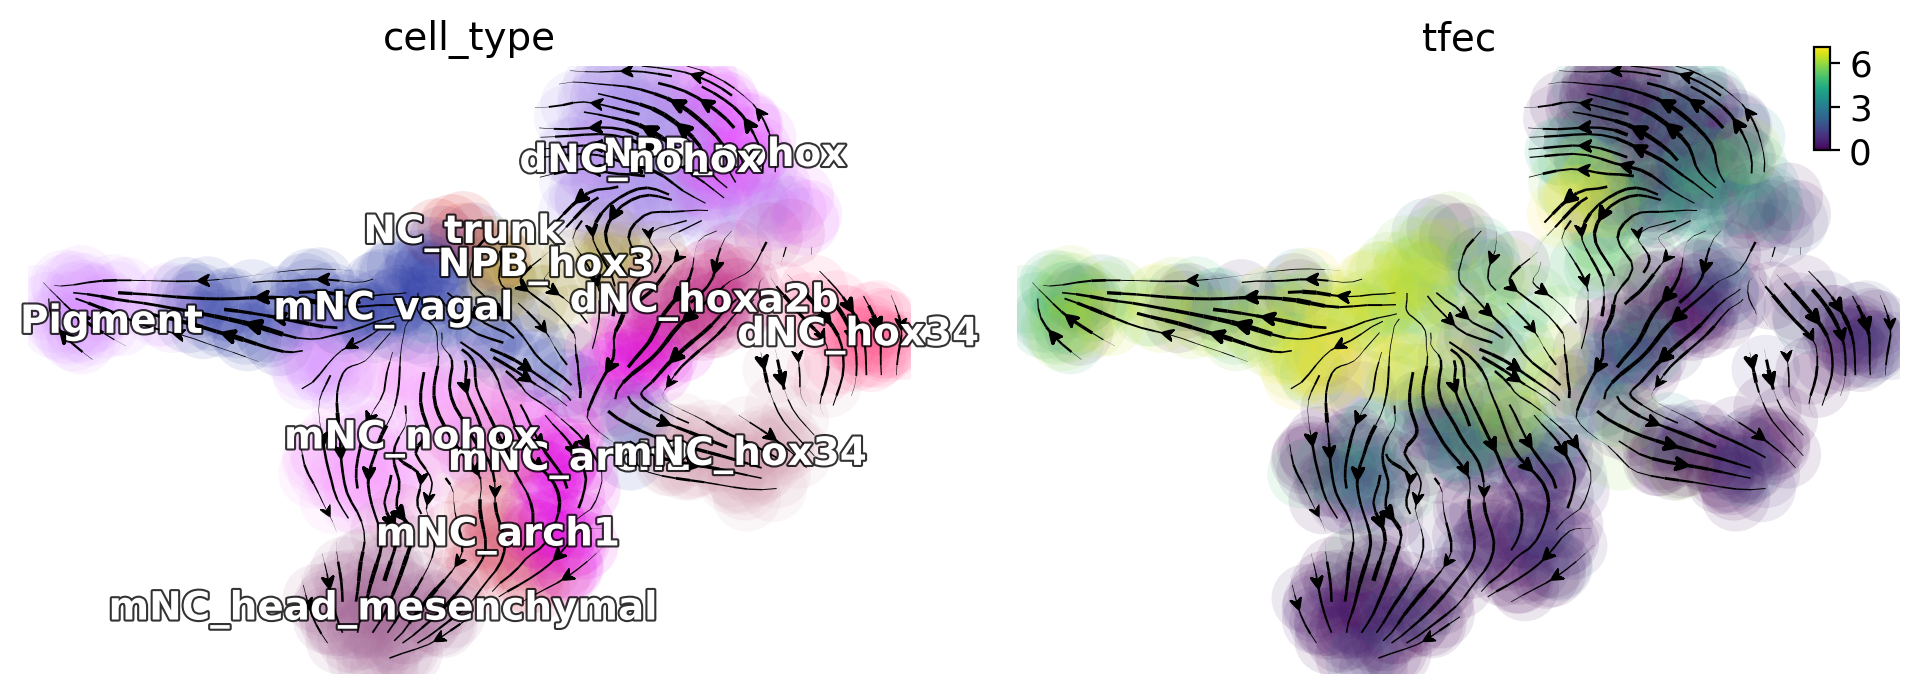

In [18]:
gene = "tfec"
vf = dyn.pd.KO(adata_perturb, gene, emb_basis="umap",store_vf_ko = True)
dyn.pl.streamline_plot(adata_perturb, color=["cell_type", gene], basis="umap_KO")
plt.show()

In [19]:
adata_perturb_pca = ad.AnnData(adata_perturb.obsm["X_pca_KO"])
adata_perturb_pca.layers["Ms"] = adata_perturb.obsm["X_pca_KO"]
adata_perturb_pca.layers["velocity"] = adata_perturb.obsm["velocity_pca_KO"]
adata_perturb_pca.obs = adata_perturb.obs.copy()
adata_perturb_pca.uns = adata_perturb.uns.copy()
adata_perturb_pca.obsp = adata_perturb.obsp.copy()
del adata_perturb_pca.uns["cell_type_colors"]

In [20]:
terminal_states = [
        "mNC_head_mesenchymal",
        "mNC_arch2",
        "mNC_hox34",
        "Pigment",
    ]

vk = cr.kernels.VelocityKernel(adata_perturb_pca)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
g2 = cr.estimators.GPCCA(0.8*vk+0.2*ck)
## evaluate the fate prob on original space
g2.compute_macrostates(n_states=8, n_cells = 30,cluster_key="cell_type")
## set a high number of states, and merge some of them and rename
if terminal_states is None:
    g2.predict_terminal_states()
    terminal_states = g2.terminal_states.cat.categories.tolist()
g2.set_terminal_states(
    terminal_states
)
#g2 = g2.rename_terminal_states({"Mono_1": "Mono","DCs_1":"DC"})
g2.compute_fate_probabilities(solver="direct")
fate_prob2 = g2.fate_probabilities

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Defaulting to `'gmres'` solver.


  0%|          | 0/4 [00:00<?, ?/s]

|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_type by stack threshold when stacking color because it is not a numeric type


/home/icb/weixu.wang/.local/lib/python3.10/site-packages/dynamo/plot/scVectorField.py:1621: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


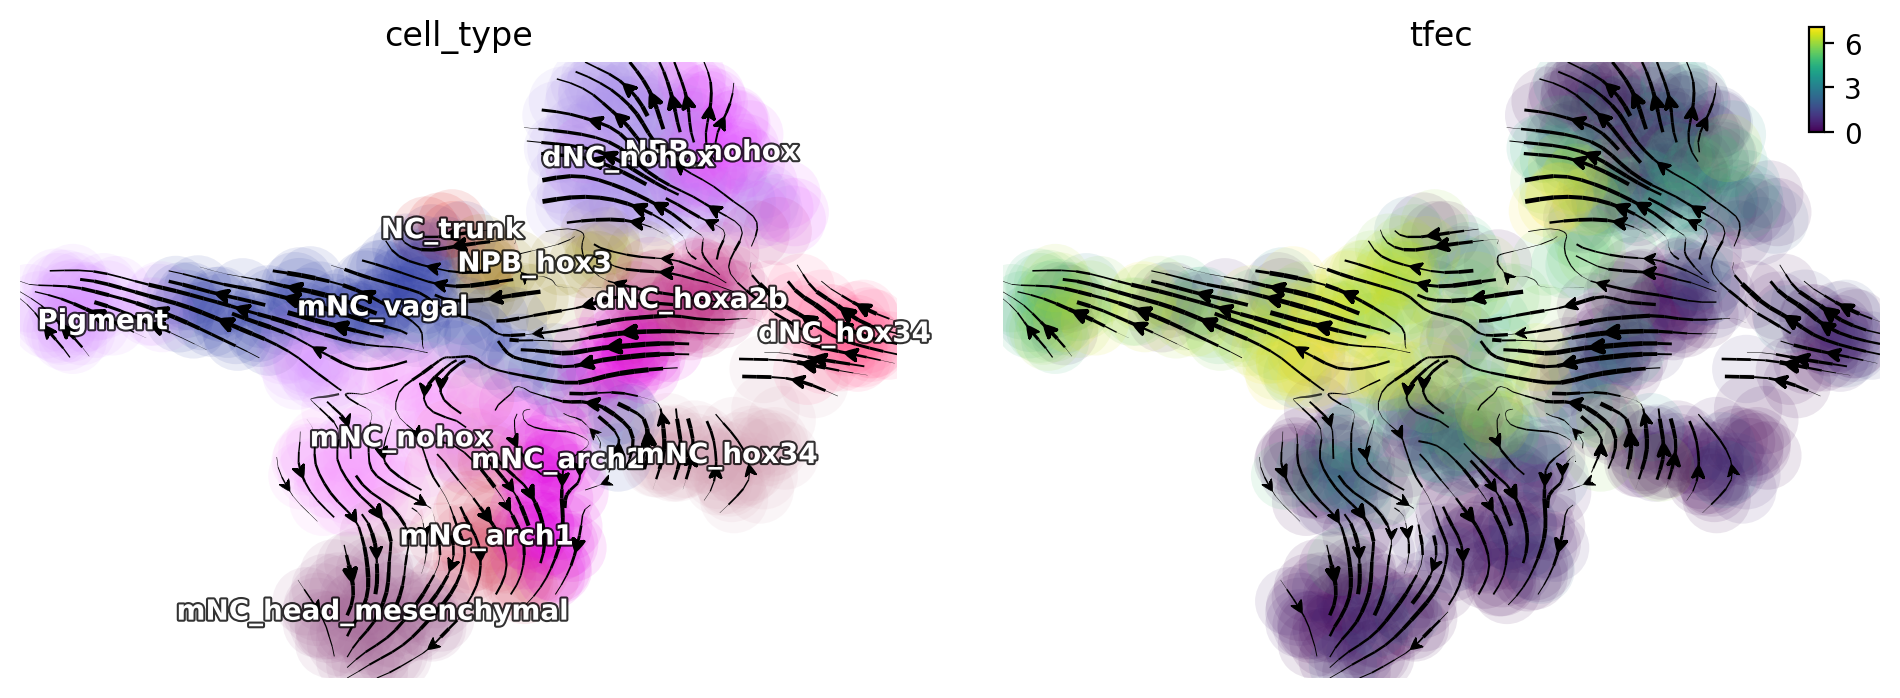

In [21]:
dyn.pl.streamline_plot(adata, color=["cell_type", gene], basis="umap")

In [22]:
gene_list = ['elk3',
 'erf',
 'etv2',
 'fli1a',
 'mitfa',
 'nr2f5',
 'rarga',
 'rxraa',
 'smarcc1a',
 'tfec']

In [23]:
gene_list = set(gene_list).intersection(adata.var_names)
gene_list = list(gene_list)
len(gene_list)

8

In [24]:
terminal_states = [
        "mNC_head_mesenchymal",
        "mNC_arch2",
        "mNC_hox34",
        "Pigment",
    ]

## Single knock-out perturbation simulation

In [25]:
del adata.uns["cell_type_colors"]

In [26]:
d = TFScanning_KO(adata,8,"cell_type",terminal_states,gene_list)

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

|-----> In silico knockout rxraa
|-----> Project the high dimensional vector field after KO to umap.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.2530s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.2453s]


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

Done rxraa
|-----> In silico knockout elk3
|-----> Project the high dimensional vector field after KO to umap.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.2245s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.1763s]


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

Done elk3
|-----> In silico knockout nr2f5
|-----> Project the high dimensional vector field after KO to umap.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.3267s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.3522s]


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

Done nr2f5
|-----> In silico knockout erf
|-----> Project the high dimensional vector field after KO to umap.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.3061s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.3188s]


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

Done erf
|-----> In silico knockout mitfa
|-----> Project the high dimensional vector field after KO to umap.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.2907s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.2953s]


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

Done mitfa
|-----> In silico knockout rarga
|-----> Project the high dimensional vector field after KO to umap.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.2289s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.1822s]


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

Done rarga
|-----> In silico knockout tfec
|-----> Project the high dimensional vector field after KO to umap.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.2496s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.1664s]


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

Done tfec
|-----> In silico knockout fli1a
|-----> Project the high dimensional vector field after KO to umap.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.3916s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.3630s]


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

Done fli1a


In [27]:
d2 = TFScanning_perturbation(adata,8,"cell_type",terminal_states,gene_list)

|-----> In silico perturbation of single-cells and prediction of cell fate after perturbation...
|-----> Retrive X_pca, PCs, pca_mean...
|-----> Calculate perturbation effect matrix via \delta Y = J \dot \delta X....


calculating Jacobian for each cell: 100%|██████████| 697/697 [00:00<00:00, 95878.45it/s]

|-----> project the pca perturbation vector to low dimensional space....


|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.2681s]
|-----> you can use dyn.pl.streamline_plot(adata, basis='umap_perturbation') to visualize the perturbation vector
Done rxraa
|-----> In silico perturbation of single-cells and prediction of cell fate after perturbation...
|-----> Retrive X_pca, PCs, pca_mean...
|-----> Calculate perturbation effect matrix via \delta Y = J \dot \delta X....
|-----> project the pca perturbation vector to low dimensional space....
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.2293s]
|-----> you can use dyn.pl.streamline_plot(adata, basis='umap_perturbation') to visualize the perturbation vector
Done elk3
|-----> In silico perturbation of single-cells and prediction of cell fate after perturbation...
|-----> Retrive 

In [28]:
## Perform KO screening using function based perturbation
coef = pd.DataFrame(np.array(d['coefficient']))
coef.index = d['TF']
coef.columns = get_list_name(d['coefficient'][0])

In [29]:
coef2 = pd.DataFrame(np.array(d2['coefficient']))
coef2.index = d2['TF']
coef2.columns = get_list_name(d2['coefficient'][0])

In [30]:
coef = coef.loc[gene_list,:]
coef2 = coef2.loc[gene_list,:]

In [31]:
## read the perturbation results and perform benchmark
gt = perturbation.copy()
gt = gt.loc[[i in coef.index for i in gt.loc[:,"sgRNA_group"]],:]
gt = gt.loc[[i in ["Pigment_gch2_high","mNC_hox34","mNC_arch2","mNC_head_mes"] for i in gt.loc[:,"cell_anno"]],:]

In [32]:
for tf in gene_list:
    gt.loc[[i in tf for i in gt.loc[:,"sgRNA_group"]],"median_lochness"] = gt.loc[[i in tf for i in gt.loc[:,"sgRNA_group"]],"median_lochness"] / np.mean(gt.loc[[i in tf for i in gt.loc[:,"sgRNA_group"]],"median_lochness"])

In [33]:
terminal_states = ["Pigment","mNC_hox34","mNC_arch2","mNC_head_mesenchymal"]
coef = coef.loc[:,terminal_states]
coef.columns = ["Pigment_gch2_high","mNC_hox34","mNC_arch2","mNC_head_mes"]
coef2 = coef2.loc[:,terminal_states]
coef2.columns = ["Pigment_gch2_high","mNC_hox34","mNC_arch2","mNC_head_mes"]

In [34]:
pred_effect = []
TF = []
for i in range(gt.shape[0]):
    ts = gt.iloc[i,0]
    tf = gt.iloc[i,2]
    effect = (coef.loc[tf,ts]+1)/2
    pred_effect.append(effect)
    TF.append(tf)

In [35]:
pred = pd.DataFrame({"TF":TF,"effect":pred_effect})
scipy.stats.spearmanr(pred.iloc[:,1], gt.iloc[:,1])

SignificanceResult(statistic=0.11766862170087976, pvalue=0.5212722285804524)

In [36]:
pred_effect = []
TF = []
for i in range(gt.shape[0]):
    ts = gt.iloc[i,0]
    tf = gt.iloc[i,2]
    effect = (coef2.loc[tf,ts]+1)/2
    pred_effect.append(effect)
    TF.append(tf)

In [37]:
pred = pd.DataFrame({"TF":TF,"effect":pred_effect})
scipy.stats.spearmanr(pred.iloc[:,1], gt.iloc[:,1])

SignificanceResult(statistic=0.08431085043988269, pvalue=0.6463941103586255)

## Double knock-out

In [38]:
multiple_ko = ["fli1a_elk3","mitfa_tfec","tfec_mitfa_bhlhe40","fli1a_erf_erfl3","erf_erfl3"]
multiple_ko_list = split_elements(multiple_ko)

In [39]:
d = Multiple_TFScanning_KO(adata,9,"cell_type",terminal_states,multiple_ko_list)

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

|-----> In silico knockout ['fli1a', 'elk3']
|-----> Project the high dimensional vector field after KO to umap.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.3200s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.3252s]


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

['fli1a', 'elk3']
Done fli1a_elk3
|-----> In silico knockout ['mitfa', 'tfec']
|-----> Project the high dimensional vector field after KO to umap.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.3779s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.3749s]


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

['mitfa', 'tfec']
Done mitfa_tfec
|-----> In silico knockout ['tfec', 'mitfa', 'bhlhe40']
|-----> Project the high dimensional vector field after KO to umap.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.2875s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.2526s]


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

['tfec', 'mitfa', 'bhlhe40']
Done tfec_mitfa_bhlhe40
|-----> In silico knockout ['fli1a', 'erf', 'erfl3']
|-----> Project the high dimensional vector field after KO to umap.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.2806s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.2943s]


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

['fli1a', 'erf', 'erfl3']
Done fli1a_erf_erfl3
|-----> In silico knockout ['erf', 'erfl3']
|-----> Project the high dimensional vector field after KO to umap.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.2408s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.1770s]


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/5 [00:00<?, ?/s]

['erf', 'erfl3']
Done erf_erfl3


In [40]:
coef = pd.DataFrame(np.array(d['coefficient']))
coef.index = d['TF']
coef.columns = get_list_name(d['coefficient'][0])

In [41]:
## read the perturbation results and perform benchmark
gt = perturbation.copy()
gt = gt.loc[[i in coef.index for i in gt.loc[:,"sgRNA_group"]],:]
gt = gt.loc[[i in ["Pigment_gch2_high","mNC_hox34","mNC_arch2","mNC_head_mes"] for i in gt.loc[:,"cell_anno"]],:]

In [42]:
for tf in coef.index:
    gt.loc[[i in tf for i in gt.loc[:,"sgRNA_group"]],"median_lochness"] = gt.loc[[i in tf for i in gt.loc[:,"sgRNA_group"]],"median_lochness"] / np.mean(gt.loc[[i in tf for i in gt.loc[:,"sgRNA_group"]],"median_lochness"])

In [43]:
terminal_states = ["Pigment","mNC_hox34","mNC_arch2","mNC_head_mesenchymal"]
coef = coef.loc[:,terminal_states]
coef.columns = ["Pigment_gch2_high","mNC_hox34","mNC_arch2","mNC_head_mes"]

In [44]:
pred_effect = []
TF = []
for i in range(gt.shape[0]):
    ts = gt.iloc[i,0]
    tf = gt.iloc[i,2]
    effect = (coef.loc[tf,ts]+1)/2
    pred_effect.append(effect)
    TF.append(tf)

In [45]:
pred = pd.DataFrame({"TF":TF,"effect":pred_effect})
scipy.stats.spearmanr(pred.iloc[:,1], gt.iloc[:,1])

SignificanceResult(statistic=0.24360902255639094, pvalue=0.3006681944004437)

In [46]:
d2 = Multiple_TFScanning_perturbation(adata,9,"cell_type",terminal_states,multiple_ko_list)

|-----> In silico perturbation of single-cells and prediction of cell fate after perturbation...
|-----> Retrive X_pca, PCs, pca_mean...
|-----> Calculate perturbation effect matrix via \delta Y = J \dot \delta X....
|-----> project the pca perturbation vector to low dimensional space....
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.3161s]
|-----> you can use dyn.pl.streamline_plot(adata, basis='umap_perturbation') to visualize the perturbation vector
Done fli1a_elk3
|-----> In silico perturbation of single-cells and prediction of cell fate after perturbation...
|-----> Retrive X_pca, PCs, pca_mean...
|-----> Calculate perturbation effect matrix via \delta Y = J \dot \delta X....
|-----> project the pca perturbation vector to low dimensional space....
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity

In [47]:
coef = pd.DataFrame(np.array(d2['coefficient']))
coef.index = d2['TF']
coef.columns = get_list_name(d2['coefficient'][0])

In [48]:
## read the perturbation results and perform benchmark
gt = perturbation.copy()
gt = gt.loc[[i in coef.index for i in gt.loc[:,"sgRNA_group"]],:]
gt = gt.loc[[i in ["Pigment_gch2_high","mNC_hox34","mNC_arch2","mNC_head_mes"] for i in gt.loc[:,"cell_anno"]],:]

In [49]:
for tf in coef.index:
    gt.loc[[i in tf for i in gt.loc[:,"sgRNA_group"]],"median_lochness"] = gt.loc[[i in tf for i in gt.loc[:,"sgRNA_group"]],"median_lochness"] / np.mean(gt.loc[[i in tf for i in gt.loc[:,"sgRNA_group"]],"median_lochness"])

In [50]:
terminal_states = ["Pigment","mNC_hox34","mNC_arch2","mNC_head_mesenchymal"]
coef = coef.loc[:,terminal_states]
coef.columns = ["Pigment_gch2_high","mNC_hox34","mNC_arch2","mNC_head_mes"]

In [51]:
pred_effect = []
TF = []
for i in range(gt.shape[0]):
    ts = gt.iloc[i,0]
    tf = gt.iloc[i,2]
    effect = (coef.loc[tf,ts]+1)/2
    pred_effect.append(effect)
    TF.append(tf)

In [52]:
import scipy
pred = pd.DataFrame({"TF":TF,"effect":pred_effect})
scipy.stats.spearmanr(pred.iloc[:,1], gt.iloc[:,1])

SignificanceResult(statistic=0.14586466165413534, pvalue=0.5394664944297437)